# Auto1 Data Science Challenge



Question 1 (10 Points)
List as many use cases for the dataset as possible.

1. Pricing. Given historic data, how should we price cars that are similar? Which attributes and individual coefficients contribute the most to car price predictability & correlation? (PCA, multiple linear regression, ML random forest regressors, clustering) 
2. Safety. Given historic data, we can predict, which symboling (-3 to 3) or binary (positive or neutral vs. negative) risk assessment a car should receive or be classified as. What is the effect of normalised-losses on risk assessment? (multiple logistic regression, linear discriminant analysis, gradient boosting & random forest classifiers, clustering)
3. Fuel-efficiency. Given historic data, which factors correlate with MPG? How does this relate to pricing? Which attributes and individual coefficients contribute the most to car MPG predictability & correlation? What are the average specs of a fuel-efficient car vs. a gas guzzler (PCA, multiple linear regression, ML random forest regressors, clustering)
4. Make & Manufacturer Country: Are car brands significant, when it comes to pricing, safety, & fuel-efficiency? Which car manufacturers are the riskiest purchases, most/least fuel-efficient, &/or expensive? Translating the 'make' field based on manufacturer's geography, which countries produce the most expensive, most fuel-efficient, & less riskiest cars according to the data. Enrich by joining sales data (chi-sq, ANOVA)

-----------

Question 2 (10 Points)
Auto1 has a similar dataset (yet much larger...) 
Pick one of the use cases you listed in question 1 and describe how building a statistical model based on the dataset could best be used to improve Auto1’s business.

N.B. Originally wanted to tackle first topic, but price & logPrice are not normal including their residuals.

1. Topic: Fuel-Efficiency
2. Driving Questions: 
    1. Which attributes more broadly affect fuel-efficiency represented as MPG?  
    2. Which coefficients individually & independently contribute the most to car fuel-efficiency predictability & correlation?
    3. What are the avg. specs of a fuel-efficient car vs. a gas guzzler according to the data.
3. Methods: 
    1. Reduce dimensionality to find broader trends in the data: 
        * PCA or corr_plots for broader examination of variance & correlation; 
        * normal distribution test (k-smirnov) & probplots checking residual error distribution. 
    2. Isolate the strongest correlates with fuel-efficiency, whilst handling multi-collinearity in Multiple Linear Regression. 
4. Dataset Characteristics:
        * N = 205
        * Attributes (features) = 26
        * Attribute Characteristics: Categorical, Integer, Real
        * Rows with Missing Values = 46
        * Nulls = 61
            - Linear Regression imputing NaNs
            
            
------------

 
Question 3 (20 Points)
Implement the model you described in question 2 in R or Python. The code has to retrieve the data, train and test a statistical model, and report relevant performance criteria. 
 
When submitting the challenge, send us the link for a Git repository containing the code for analysis and the potential pre-processing steps you needed to apply to the dataset. You can use your own account at github.com or create a new one specifically for this challenge if you feel more comfortable.
 
Ideally, we should be able to replicate your analysis from your submitted source-code, so please explicit the versions of the tools and packages you are using (R, Python, etc).
 
 
Question 4 (60 Points)
A. Explain each and every of your design choices (e.g., preprocessing, model selection, hyper parameters, evaluation criteria). Compare and contrast your choices with alternative methodologies. 
 
 A.1 Data Pre-processing:
        * Coerce '?' into NaN
        * Replace '-' with '_' for feature names
        * binarise, dummify, encode, label, replace, etc. necessary categorical variables
        * Merge city-mpg & highway-mpg as an avg_mpg.
        * Impute NaNs mean for normally distributed data & median for not-normal 
        * Log-Normal transformation, when continuous features are not normally distributed. 
            - Check residuals for variables that do not become normal after log.
            - Make sure avg_mpg is normal. 
        * Standardisation: (observation-mean)/standard_deviation; important to center & remove units differentiation.
A.2 Exploratory Analysis:
        * Pearson's Covariance Matrix (between 0.3 to -0.3 is lower collinearity == acceptable threshold)
        * If more than 1 variable are collinear (0.90+), choose best correlate for predicting MPG and remove the others. If correlation of independent & dependent between 0.10 & -0.10 consider removal. 
A.3 Model Selection
        * Multiple Linear Regression
            - Assumptions: 
                * Linear relationship
                * Multivariate normality (normal_distribution_test,probplots; h0=The array comes from a normal distribution; log-transformation of skewed distributions.)
                * Little to no multicollinearity (acceptable collinearity defined as between 0.3 to -0.3 pearson's; standardisation or centering of data;
                * No auto-correlation. (Not dealing with time-series data.)
                * Homoscedastic: residuals are equal across the regression line; probplot
            - KPIs: 
                * R2; 
                * coefficient values & p-values; 
                * Confidence Interval (95% or alpha 0.05); 
                * Mean Squared Error: average squared difference between the predicted and the true values.
                * Mean Absolute Error: average vertical or horizontal distances between the predicted and true values.
                * Median Absolute Error: median vertical or horizontal distances between the predicted and true values.
A.4 Procedure Overview:
    1. Create data frame of most variables including numeritised categorical & one-hot encoded variables
    2. Then use recursive feature elimination with cross validation (RFECV) to recursively eliminate features whilst training a regressor that's also optimising these linear regression metrics: r2, mean square error, mean & median aboslute error scores.
    3. Check the selected models for Variance Inflation Factor assuming RFECV is too greedy in selecting collinear features.(Any VIF > 10 should be removed, stepwise approach with largest VIFs removed then recalculation, etc. till no VIF > 10.)
    4. Check Model coefficients, p-values, & report all previously mentioned metrics.

------------

Sources:

https://archive.ics.uci.edu/ml/datasets/automobile

http://www.statisticssolutions.com/assumptions-of-linear-regression/

------------
 
 
 




# Question 3: Implementation of Analysis

In [64]:
import pandas as pd
import numpy as np
import math
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.metrics import explained_variance_score 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 210)



In [65]:
### Read csv into Jupyter Environment

df = pd.read_csv('Auto1-DS-TestData.csv')

In [66]:
## Remove continuous variables with ? 

continuous = list(df.describe().columns)+['bore','stroke','normalized-losses','horsepower','peak-rpm','price']
for c in continuous:
    df[c] = pd.to_numeric(df[c],errors='coerce')

na_counts = [ (i,x) for i,x in df.isnull().sum().iteritems() if x > 0]
na_counts    

[('normalized-losses', 41),
 ('bore', 4),
 ('stroke', 4),
 ('horsepower', 2),
 ('peak-rpm', 2),
 ('price', 4)]

In [67]:
## Rename data frame columns 
# (I like using series by methods & having a minus side can be a hindrance to some lin_reg libraries.)


df.columns=df.columns.map(lambda x: x.replace('-','_'))


In [68]:
### Code categorical Variables 
numbers = ['num_of_doors','num_of_cylinders']
binary = ['fuel_type','aspiration','engine_location']
categorical = ['make','body_style','engine_type','fuel_system','drive_wheels']

        
## replace, binarise, onehot-encode categorical variables with numbers:


cleanup_nums = {"num_of_doors":{"four": 4, "two": 2, '?':4},# filled ? with most frequent observation 
                 "num_of_cylinders": {"four": 4, "six": 6, "five": 5, "eight": 8,"two": 2, "twelve": 12, "three":3 }}

df.replace(cleanup_nums, inplace=True)

## label binarizer to encode binary categories

lb_style = LabelBinarizer()

for b in binary:
    df[b] = lb_style.fit_transform(df[b])


## onehot encoding for categorical variables in Python (Important to standardise to keep intercept happy.)

def make_dummies(df,features):
    #df[v].fillna("Missing", inplace=True)
    for v in features:
        dummies = pd.get_dummies(df[v])
        df = pd.concat([df,dummies], axis=1) 
        df.drop([v], axis=1, inplace=True)
    return df

### N.B. I will enact make_dummies function after my preliminary analysis

In [69]:
def identify_normal_distributions(df):
    
    for i in df.describe().columns:
        x = scipy.stats.normaltest(df[i], axis=0, nan_policy='omit')
        if x.pvalue > 0.05: ## H0: The distribution is normal. We want high p-values, because we want to find instances, where H0==True. 
            print(i)
            
identify_normal_distributions(df)  

# only 4/26 columns are normally distributed,we must log-transform & standardise; we are only concerned about the continuous variables 


num_of_doors
length
height
peak_rpm


In [70]:
### Visualise correlations with Pearson's Covariance Matrix 

def show_corr(df,sort):
    
    corr = df.corr()
    graphic = sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values)

    return  graphic, corr.sort_values(sort,ascending=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x116472a58>,
                    symboling  normalized_losses  fuel_type  aspiration  \
 highway_mpg            0.035             -0.211     -0.191      -0.254   
 city_mpg              -0.036             -0.259     -0.256      -0.202   
 compression_ratio     -0.179             -0.133     -0.984       0.296   
 symboling              1.000              0.529      0.194      -0.060   
 num_of_doors          -0.664             -0.402     -0.188       0.053   
 stroke                -0.009              0.066     -0.242       0.223   
 peak_rpm               0.275              0.265      0.477      -0.184   
 engine_location        0.212                nan      0.040      -0.057   
 height                -0.541             -0.432     -0.285       0.087   
 fuel_type              0.194              0.117      1.000      -0.401   
 normalized_losses      0.529              1.000      0.117      -0.008   
 aspiration            -0.060             -

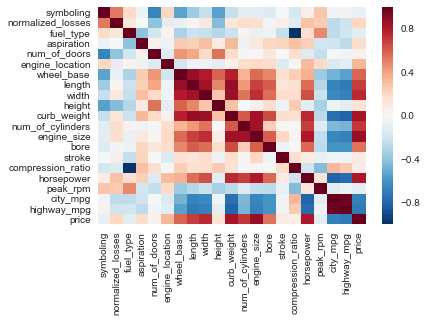

In [71]:
show_corr(df,'highway_mpg')


In [72]:
# Examine correlations specifically at mpg

# merge city & highway mpgs for avg_mpg
# symboling, doors, stroke, peak rpm weakly correlate with mpg consider removing
# clear multicollinearity

corr=df.corr()

corr[corr.values>=0.9].duplicated()

#corr[corr.values>=0.8].duplicated()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


symboling            False
normalized_losses    False
fuel_type            False
aspiration           False
num_of_doors         False
engine_location      False
wheel_base           False
length               False
width                False
height               False
curb_weight          False
num_of_cylinders     False
engine_size          False
bore                 False
stroke               False
compression_ratio    False
horsepower           False
peak_rpm             False
city_mpg             False
city_mpg              True
highway_mpg          False
highway_mpg           True
price                False
dtype: bool

# I. Preliminary Analysis: 

As the correlation matrix shows only 4/21 continuous features positively correlate, whilst the other features relating to the engine/power/speed/size of the car negatively correlate. 

Breakdown:
* Both mpgs highly correlate (0.97) >>> average the two for one dependent variable avg_mpg.
* MPG positively correlates with only 2 features compression_ratio (0.27) & symboling (0.04). 
* MPG negatively correlates with:

 -num_of_cylinders        -0.467  
 -wheel_base              -0.544  
 -bore                    -0.595  
 -width                   -0.677  
 -engine_size             -0.677  
 -length                  -0.705  
 -price                   -0.705  
 -horsepower              -0.771  
 -curb_weight             -0.797 
 
 * Weight, horsepower, price, length, width, engine size, cylinders, have collinearities greater than or equal to 0.80
 * Consider reducing highly correlating features by combining them parameter, volume, density of car. 
 * For optimising predictability, we will use recursive feature elimnation and will let the algorithm choose the best features without further reduction – save removing 0.90+ & attributes with low correlations to avg_mpg

# *Hypothesis*:
Fuel economy is the energy efficiency of a particular vehicle, given as a ratio of distance traveled per unit of fuel consumed. It is dependent on engine efficiency, transmission design, and tire design. Fuel economy is expressed in miles per gallon (mpg). Thus, the bigger/heavier cars with larger engines such as trucks & SUVs, or cars with more horsepower and more wasteful engines, are more likely to have higher miles per gallon (MPG) compared to smaller more compact cars with less abrasive engines &, interestingly enough, lower price tags (as such factors seem to correlate with each other). 

To prove this hypothesis we will use multiple linear regression to model gas mileage & other independent factors. 


In [73]:
### Feature Engineering, which estimators can be combined in meaningful ways to lower dimensionality of data 
# & will act as a strong predictor of Price on MPG. 

# These two collinear & measure mpg easy to think of as an avg one value.
df['avg_mpg'] = (df.city_mpg+df.highway_mpg)/2
df.drop(['city_mpg','highway_mpg'],axis=1,inplace=True)

#Power-to-weight ratio is a measurement of actual performance of any engine or power source & often used by car dealers.
#df['power_to_weight'] = df.horsepower/df.curb_weight
#df['weight_to_power'] = df.curb_weight/df.horsepower
#df.drop(['horsepower','curb_weight'],axis=1,inplace=True)

#In a reciprocating piston engine, the stroke ratio, defined by either bore/stroke ratio or stroke/bore ratio, 
#is a term to describe the ratio between cylinder bore diameter and piston stroke.
#df['bore_stroke'] = df.bore/df.stroke
#df.drop(['bore','stroke'],axis=1,inplace=True)

#df['parameter'] = df.length*df.width
#df['volume'] = df.length*df.width*df.height
#df['density'] = df.curb_weight/df.volume
#df.drop(['length','width'],axis=1,inplace=True)



Next, we Log-transform all continuous variables by the natural log with inverse being e**(log(observation)) or exp(log(observation)), for readability it is sometimes nice to use log10 or log2. We do this so that the underlying linearity or normality of the skewed distributions reveals itself. Thus, we should expect correlation values to be slightly bigger. In logistic & linear regression, log transformed dependent variables as a function of log-transformed independent coefficients are interepreted elastically. The base of the log used to transform constitutes the magnitude of the effect of the independent variable on the dependent one. I cover this in coefficient interpretation section.

In [74]:
# Continuous variables
continuous=['normalized_losses','length','width',
       'height', 'curb_weight','engine_size', 'bore',
       'stroke', 'compression_ratio', 'horsepower','curb_weight', 'peak_rpm', 'avg_mpg',
        'price','wheel_base']

In [75]:
for i in continuous:
    df[i]=df[i].apply(lambda x: math.log(float(x)))

In [76]:
identify_normal_distributions(df)

print(na_counts)

normalized_losses
num_of_doors
length
height
peak_rpm
avg_mpg
[('normalized-losses', 41), ('bore', 4), ('stroke', 4), ('horsepower', 2), ('peak-rpm', 2), ('price', 4)]


In [77]:
## Impute NaNs for Linear Regression (if larger dataset perhaps imputing with K-NN or other ML clustering method would be optimal.)

## Fillna of normally distributed with mean of column
imp_mean = Imputer(strategy='mean', axis=0, verbose=0, copy=False)

df[['normalized_losses','peak_rpm']]=imp_mean.fit_transform(df[['normalized_losses','peak_rpm']])

## Fill of variables with close to but not normal distributions with median of column
imp_median = Imputer(strategy='median', axis=0, verbose=0, copy=False)

df[['bore','stroke','horsepower','price']]=imp_median.fit_transform(df[['bore','stroke','horsepower','price']])
#weight-to-power

In [78]:
# Finally one-hot encode the remaining categorical variables 
df=make_dummies(df,categorical)

In [79]:
# clean column names of alphanumerics: 

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

name_changes = {'4':'four','1':'one','2':'two','-':'_'}

change_column_names = ' '.join(df.columns)
change_column_names = replace_all(change_column_names,name_changes)

df.columns = change_column_names.split()


In [80]:
df.columns

Index(['symboling', 'normalized_losses', 'fuel_type', 'aspiration',
       'num_of_doors', 'engine_location', 'wheel_base', 'length', 'width',
       'height', 'curb_weight', 'num_of_cylinders', 'engine_size', 'bore',
       'stroke', 'compression_ratio', 'horsepower', 'peak_rpm', 'price',
       'avg_mpg', 'alfa_romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'mercedes_benz', 'mercury', 'mitsubishi',
       'nissan', 'peugot', 'plymouth', 'porsche', 'renault', 'saab', 'subaru',
       'toyota', 'volkswagen', 'volvo', 'convertible', 'hardtop', 'hatchback',
       'sedan', 'wagon', 'dohc', 'dohcv', 'l', 'ohc', 'ohcf', 'ohcv', 'rotor',
       'onebbl', 'twobbl', 'fourbbl', 'idi', 'mfi', 'mpfi', 'spdi', 'spfi',
       'fourwd', 'fwd', 'rwd'],
      dtype='object')

In [85]:
### Standardise the data, thereby, centering & removing units differentiation
scaler = StandardScaler()
df[continuous]=scaler.fit_transform(df[continuous])

df.describe()

,symboling,normalized_losses,fuel_type,aspiration,num_of_doors,engine_location,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,price,avg_mpg,alfa_romero,audi,bmw,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercedes_benz,mercury,mitsubishi,nissan,peugot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo,convertible,hardtop,hatchback,sedan,wagon,dohc,dohcv,l,ohc,ohcf,ohcv,rotor,onebbl,twobbl,fourbbl,idi,mfi,mpfi,spdi,spfi,fourwd,fwd,rwd
count,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000,205.000
mean,0.834,0.000,0.902,0.180,3.132,0.015,-0.000,0.000,0.000,-0.000,0.000,4.380,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.015,0.034,0.039,0.015,0.044,0.063,0.020,0.015,0.083,0.039,0.005,0.063,0.088,0.054,0.034,0.024,0.010,0.029,0.059,0.156,0.059,0.054,0.029,0.039,0.341,0.468,0.122,0.059,0.005,0.059,0.722,0.073,0.063,0.020,0.054,0.322,0.015,0.098,0.005,0.459,0.044,0.005,0.044,0.585,0.371
std,1.245,1.002,0.297,0.386,0.994,0.120,1.002,1.002,1.002,1.002,1.002,1.081,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,0.120,0.182,0.194,0.120,0.205,0.244,0.139,0.120,0.276,0.194,0.070,0.244,0.284,0.226,0.182,0.155,0.099,0.169,0.235,0.364,0.235,0.226,0.169,0.194,0.475,0.500,0.328,0.235,0.070,0.235,0.449,0.261,0.244,0.139,0.226,0.468,0.120,0.297,0.070,0.499,0.205,0.070,0.205,0.494,0.484
min,-2.000,-2.328,0.000,0.000,2.000,0.000,-2.188,-2.931,-2.759,-2.551,-2.725,2.000,-2.442,-3.277,-4.413,-1.142,-2.072,-2.210,-1.627,-2.524,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,-0.587,1.000,0.000,2.000,0.000,-0.714,-0.608,-0.852,-0.696,-0.784,4.000,-0.799,-0.638,-0.403,-0.411,-0.975,-0.654,-0.781,-0.807,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,1.000,0.000,1.000,0.000,4.000,0.000,-0.273,-0.034,-0.178,0.176,-0.177,4.000,-0.045,-0.031,0.151,-0.249,-0.087,0.202,-0.219,-0.034,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,2.000,0.617,1.000,0.000,4.000,0.000,0.642,0.752,0.482,0.739,0.808,4.000,0.526,0.930,0.504,-0.095,0.494,0.801,0.732,0.685,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000
max,3.000,3.087,1.000,1.000,4.000,1.000,3.446,2.561,2.905,2.382,2.398,12.000,3.496,2.105,2.485,3.083,3.137,2.751,2.771,2.701,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


# Model Selection 

Feature selection with recursive feature elimination and 15 cross-validation folds in 1 to 10 step reduction approaches to get the best number of features based on maximising R2, estimated-variance, 'neg_mean_absolute_error','neg_median_absolute_error', 'neg_mean_squared_error'. 


In [86]:
### Using RFECV 

# Create estimator
estimator = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)

# Create params
metrics = ('r2','neg_mean_squared_error','neg_mean_absolute_error','neg_median_absolute_error')
steps = (1,3,5,10)
list_of_features = []

# Create train|test 
df_rfecv = df.copy()
y = df_rfecv.pop('avg_mpg')


for m in metrics:
    for s in steps:
        
        selector = RFECV(estimator, scoring=m, step=s, cv=15, verbose=0)
        selector.fit_transform(df_rfecv,y)
        selections = selector.get_support(indices=True)
        
        list_of_features.append((m,s,'avg_mpg',selections))
    
rfecv_results=pd.DataFrame(list_of_features,columns=['score','steps','target','features'])

## extract feature name by column index
feature_set =set([item for slist in rfecv_results.features for item in slist])
feature_names = [(x,df_rfecv[df_rfecv.columns[x]].name) for x in feature_set]
feature_df = pd.DataFrame(feature_names,columns=['column_int','feature'])
feature_dict = dict(zip(list(feature_df.column_int), list(feature_df.feature)))
rfecv_results.features = [list(map(feature_dict.get, i)) for i in rfecv_results.features]
rfecv_results['feature_count']=[len(i)for i in rfecv_results.features]

/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
/anaconda/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` 

In [87]:
#Model Selection Results:
rfecv_results

,score,steps,target,features,feature_count
0,r2,1,avg_mpg,"[curb_weight, horsepower, audi, chevrolet, mer...",8
1,r2,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",10
2,r2,5,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",14
3,r2,10,avg_mpg,"[symboling, normalized_losses, fuel_type, aspi...",64
4,neg_mean_squared_error,1,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",11
5,neg_mean_squared_error,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",13
6,neg_mean_squared_error,5,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",14
7,neg_mean_squared_error,10,avg_mpg,"[fuel_type, engine_location, curb_weight, comp...",14
8,neg_mean_absolute_error,1,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",12
9,neg_mean_absolute_error,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",10


In [88]:
### Examine the Variance Inflation Factors. If there are no VIFs over 10 then model is okay to use. 

def vif(df): 
    
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif = vif.round()
    vif = vif[vif['VIF Factor']>10].sort_values('VIF Factor',ascending=False)
    
    return vif

### Count & print the number of variables with VIF > 10
index_list = []
for i,e in rfecv_results.features.iteritems():
    features = "+".join(e)
    # get y and X dataframes based on this regression:
    y, X = dmatrices('avg_mpg ~' + features, df, return_type='dataframe')
    if len(vif(X)) == 0:
        index_list.append(i)
        print(i,len(vif(X)))
    
model_selections=rfecv_results[rfecv_results.index.isin(index_list)]
model_selections

0 0
1 0


/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


4 0
5 0
9 0
10 0
12 0
13 0
14 0


,score,steps,target,features,feature_count
0,r2,1,avg_mpg,"[curb_weight, horsepower, audi, chevrolet, mer...",8
1,r2,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",10
4,neg_mean_squared_error,1,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",11
5,neg_mean_squared_error,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",13
9,neg_mean_absolute_error,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",10
10,neg_mean_absolute_error,5,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",9
12,neg_median_absolute_error,1,avg_mpg,"[curb_weight, horsepower, audi, chevrolet, doh...",7
13,neg_median_absolute_error,3,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",10
14,neg_median_absolute_error,5,avg_mpg,"[curb_weight, compression_ratio, horsepower, a...",9


# Results

In [89]:
### Isolate the best model by examining the highest r2 with lowest errors


def linear_regress(X,y):
    
    #X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    reg =  LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=1)
    fit = reg.fit(X,y)
    r2_train = reg.score(X,y)
    
    y_pred = fit.predict(X)
    r2_test = r2_score(y,y_pred)
    evs = explained_variance_score(y,y_pred)
    mean_ae = mean_absolute_error(y,y_pred)
    mean_se = mean_squared_error(y,y_pred)
    median_ae = median_absolute_error(y,y_pred)
    
    target = pd.DataFrame(y).columns[0]
        
    results = pd.DataFrame([target, r2_test, mean_ae, median_ae, mean_se],index=['target','r2','mean_ae','median_ae','mean_se'])
    
    coeff = pd.DataFrame(reg.coef_,index=X.columns,columns=['coefficients']).sort_values('coefficients',ascending=False)
    
    return coeff, results

for i in model_selections.index:
    print(i,linear_regress(df[rfecv_results.iloc[i,3]],df.avg_mpg))

0 (               coefficients
dohcv                 1.641
chevrolet             0.553
mercedes_benz        -0.129
curb_weight          -0.309
audi                 -0.490
fourbbl              -0.504
horsepower           -0.634
rotor                -0.820,                  0
target     avg_mpg
r2           0.883
mean_ae      0.254
median_ae    0.174
mean_se      0.117)
1 (                   coefficients
dohcv                     1.075
chevrolet                 0.496
compression_ratio         0.285
isuzu                     0.202
mercedes_benz            -0.305
fourbbl                  -0.325
horsepower               -0.353
audi                     -0.378
curb_weight              -0.547
rotor                    -1.055,                  0
target     avg_mpg
r2           0.933
mean_ae      0.188
median_ae    0.143
mean_se      0.067)
4 (                   coefficients
dohcv                     1.066
chevrolet                 0.497
compression_ratio         0.286
isuzu                     0

In [90]:
### Turns out ** Model 4 ** Performs the best out of all models selected by RFECV

model_4 = df[rfecv_results.iloc[4,3]]

X2 = sm.add_constant(model_4)
est = sm.OLS(df.avg_mpg, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                avg_mpg   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     254.1
Date:                Wed, 20 Jun 2018   Prob (F-statistic):          2.11e-108
Time:                        13:09:40   Log-Likelihood:                -10.079
No. Observations:                 205   AIC:                             44.16
Df Residuals:                     193   BIC:                             84.03
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0428      0.02

(<matplotlib.axes._subplots.AxesSubplot at 0x1166c8588>,
                    curb_weight  compression_ratio  horsepower  alfa_romero  \
 rotor                   -0.026             -0.013       0.043       -0.017   
 fourbbl                 -0.030             -0.012       0.011       -0.015   
 horsepower               0.794             -0.267       1.000        0.083   
 dohcv                    0.104              0.009       0.220       -0.009   
 compression_ratio        0.106              1.000      -0.267       -0.030   
 chevrolet               -0.228             -0.004      -0.163       -0.015   
 alfa_romero              0.033             -0.030       0.083        1.000   
 isuzu                   -0.098             -0.023      -0.101       -0.017   
 curb_weight              1.000              0.106       0.794        0.033   
 audi                     0.103             -0.096       0.109       -0.023   
 mercedes_benz            0.390              0.226       0.227       -0.02

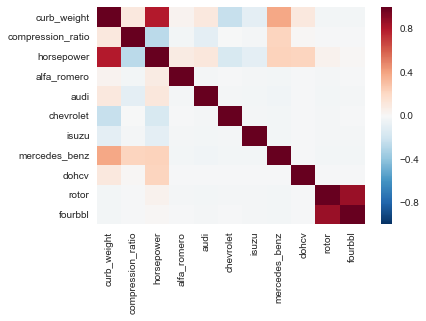

In [91]:
show_corr(model_4,'rotor')

In [92]:
## Remove alpha_romero, fourbbl, & isuzu --- they are insignificant with p values > 0.05
# this will lower the condition number, which estimates multicollinearity in a model below <30 is best.
model_4_a = model_4[['curb_weight', 'compression_ratio', 'horsepower', 'audi',
       'chevrolet', 'mercedes_benz', 'dohcv', 'rotor']]

In [99]:
# Model Results without insignificant coefficients:

X2 = sm.add_constant(model_4_a)
est = sm.OLS(df.avg_mpg, X2)
est2 = est.fit()
print(est2.summary(),est2.conf_int(0.05))

                            OLS Regression Results                            
Dep. Variable:                avg_mpg   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     345.9
Date:                Wed, 20 Jun 2018   Prob (F-statistic):          3.44e-111
Time:                        13:42:28   Log-Likelihood:                -12.488
No. Observations:                 205   AIC:                             42.98
Df Residuals:                     196   BIC:                             72.88
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0426      0.02

(<matplotlib.axes._subplots.AxesSubplot at 0x11c52f8d0>,
                    curb_weight  compression_ratio  horsepower   audi  \
 curb_weight              1.000              0.106       0.794  0.103   
 horsepower               0.794             -0.267       1.000  0.109   
 mercedes_benz            0.390              0.226       0.227 -0.038   
 compression_ratio        0.106              1.000      -0.267 -0.096   
 dohcv                    0.104              0.009       0.220 -0.013   
 audi                     0.103             -0.096       0.109  1.000   
 rotor                   -0.026             -0.013       0.043 -0.027   
 chevrolet               -0.228             -0.004      -0.163 -0.023   
 
                    chevrolet  mercedes_benz  dohcv  rotor  
 curb_weight           -0.228          0.390  0.104 -0.026  
 horsepower            -0.163          0.227  0.220  0.043  
 mercedes_benz         -0.025          1.000 -0.014 -0.028  
 compression_ratio     -0.004          0

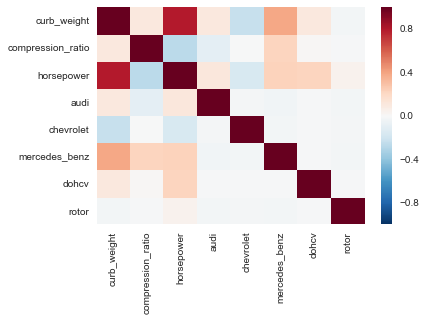

In [93]:
show_corr(model_4_a,'curb_weight')

# Interpretation of Coefficients:

* Continuous when log_log: (1.10^(logIndependent-coefficient)-1)*100 = x%
    - 10% increase in independent variables affects x% in dependent variable.
* Categoricals when dependent is log: exp(logIndependent-coefficient) = x
    - When independent categorical coefficient is chosen instead of others, you can expect a (x-1)*100 change in dependent.

In [95]:
confidence_intervals = est2.conf_int(0.05).transpose()
confidence_intervals

,const,curb_weight,compression_ratio,horsepower,audi,chevrolet,mercedes_benz,dohcv,rotor
0,0.004,-0.624,0.240,-0.426,-0.623,0.143,-0.558,0.480,-1.607
1,0.081,-0.472,0.333,-0.273,-0.218,0.765,-0.141,1.571,-1.078


In [96]:
## Continuous variables % increase or decrease, when independent variable increased by 10%

confidence_intervals[['curb_weight','compression_ratio','horsepower']].apply(lambda x: ((1.1**x)-1)*100)

,curb_weight,compression_ratio,horsepower
0,-5.775,2.317,-3.983
1,-4.401,3.221,-2.567


In [97]:
## Categorical variables % increase or decrease, when categorical variable is true.  

confidence_intervals[['audi','chevrolet','mercedes_benz','dohcv','rotor']].apply(lambda x: ((math.e**x-1)*100))

,audi,chevrolet,mercedes_benz,dohcv,rotor
0,-46.375,15.352,-42.784,61.669,-79.955
1,-19.625,114.959,-13.108,381.251,-65.988


# Synthesis 

Returning to our **hypothesis**:
Fuel economy is the energy efficiency of a particular vehicle, given as a ratio of distance traveled per unit of fuel consumed. It is dependent on engine efficiency, transmission design, and tire design. Fuel economy is expressed in miles per gallon (mpg). Thus, the bigger/heavier cars with larger engines such as trucks & SUVs, or cars with more horsepower and more wasteful engines, are more likely to have higher miles per gallon (MPG) compared to smaller more compact cars with less abrasive engines &, interestingly enough, lower price tags (as factors of weight & hp correlate with each other).
    
The results of our linear regression support these claims with coefficients based on logWeight, logHorsepower, logCompressionRatio, make, and engine type: 

# Model performance:

93% of the variation in MPG can be explained by logWeight, logHorsepower, logCompressionRatio, make, and engine type.
The model, itself, is statistically significant (f:350,p:3.44e-111).
All coefficients are extremely significant. 
The condition number is less than 30 – meaning low multicollinearity. 

# Coefficient Interpretation:

1. logWeight, logHorsepower, logCompressionRatio:
   * For every 10% increase in weight, there is a 4 to 6% decrease in MPG.
   * For every 10% increase in horsepower, there is a 3 to 4% decrease in MPG.
   * For every 10% increase in compression_ratio, there is a 2 to 3% increase in MPG. 

2. Make:
   * German Luxury car brands such as Mercedes Benz & Audi have lower MPGs on avg, whilst American Chevrolet have higher MPGs.
    * We can expect MPG to decrease by 20 to 46%, when a car is Audi instead of any others.
    * Similarly, we can expect MPG to decrease by 13 to 43%, when a car is Mercedes instead of any others.
    * Unlike the German cars, we can expect MPG to increase by 15 to 115%, when a car is an Amerrrican Chevrolet.

3. Engine Type:
    * With respect to engine type, cars with dohcv engines can be expected to increase MPG by 62 to 381% (quite a large CI;)
    * Unlike having dohcv, cars with rotor engines correlate with a 66 to 80% decrease in MPG, thus being less fuel-efficient.  

# Error Interpretations:

    * mean_ae                0.188
    * median_ae              0.138
    * mean_se                0.066
    
The mean square error is close to 0 meaning the squared mean differences between the predicted and true values is relatively close to 0 & therefore small. The mean & median absolute errors also corroborate low error meaning the vertical or horizontal distances between the predicted and true values is close to 0. 

# Conclusion:

Heavier cars or cars, more horsepower, rotor engines, & mercedes or audi have lower MPGs and are therefore less fuel-efficient than Chevrolets & dohcv engines. Additionally, higher compression ratios contribute to better fuel economy, and lower emissions. Engine type is the strongest indicator of MPG. Having a dohcv engine vs. a rotor engine can greatly impact the MPG. When taken together these factors can explain 93% of the variability in average MPG. 

Overall, these results support our beginning hypothesis. 

----------

If I could change my model, I would include a PCA or LDA analysis, streamline the code/functions, & compare performance to a nonparametric method like a gradient-boosting or random forest regressor. 


